<a href="https://colab.research.google.com/github/MisGall10/Practica_27_Misael_Gallardo/blob/main/Practica27MAGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor/a: [Nombre del estudiante]
# 📅 Fecha: [dd/mm/aaaa]
# ==========================================================================

## 🔍 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

## ==========================================================================

## 1. Cargar librerías necesarias
Escribe aquí la importación de librerías: numpy, pandas, matplotlib, seaborn, sklearn (datasets, model_selection, preprocessing, metrics, svm, kmeans), etc.

En el caso de los códigos de ENN, CNN, estos  deberás tomarlos del cuaderno que contiene la teoría y ejemplos.

In [32]:
#1. Cargar librerías necesarias
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
- Cargar el dataset con sklearn.datasets.load_breast_cancer
- Explora las dimensiones, variables, y distribución de clases

In [33]:
#2. Cargar y explorar el conjunto de datos Breast Cancer
from sklearn.datasets import load_breast_cancer
#Cargamos el conjunto de datos y lo transformamos aun data frame
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
#Dimensiones dl dataset
print('Tamaño del data set (filas,columnas):',df.shape)
#Variables/Columnas del data set
print('\nColumnas del data set:\n')
#Información del data set
print(df.info())
#Distribución de clases
print('\nDistribución de clases (target):\n')
print(df['target'].value_counts())




Tamaño del data set (filas,columnas): (569, 31)

Columnas del data set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area er

# --------------------------------------------------------------------------

## 3. Preprocesamiento
 - Escalamiento de características (StandardScaler)
 - División del conjunto en entrenamiento y prueba
 - usar hold-out de 70% y 30%



In [41]:
# 3. Preprocesamiento
#Declaramos las variables
X = df.drop('target', axis=1).values
y = df['target'].values
#Escalamos las características con StandarScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Usamos hold-out de 70% para entrenamiento y 30% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

- Aplicar CNN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



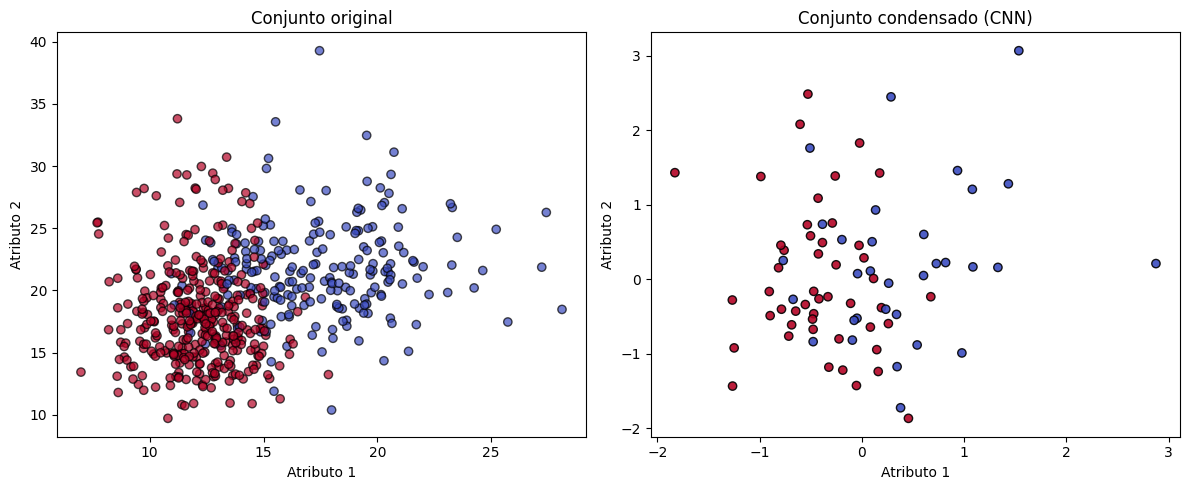

Instancias originales: 569
Instancias tras CNN:   80
Reducción: 85.94%


In [43]:
#4. Aplicar técnica CNN (Condensed Nearest Neighbor)
class CNN:
    """
    Condensed Nearest Neighbors (CNN) - versión adaptada para datos densos.

    Este algoritmo reduce el conjunto de entrenamiento reteniendo solo
    las instancias necesarias para preservar la capacidad de clasificación
    bajo la regla 1-NN (o k-NN si se ajusta n_neighbors).

    Basado en:
    P. E. Hart, The condensed nearest neighbor rule (1968).
    """

    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def select_data(self, X, y):
        # Validación de entrada: datos densos
        X, y = check_X_y(X, y, accept_sparse=False)

        idx_s = []  # índice de instancias seleccionadas
        classes = np.unique(y)
        self.classes_ = classes

        # Iniciar con una instancia aleatoria por clase
        for cur_class in classes:
            mask = np.where(y == cur_class)[0]
            choose_id = random.choice(mask)
            idx_s.append(choose_id)

        # Revisión aleatoria del resto de las instancias
        train_idx = list(range(len(y)))
        random.shuffle(train_idx)

        flag = True
        while flag:
            flag = False
            self.classifier.fit(X[idx_s], y[idx_s])
            for idx in train_idx:
                if idx not in idx_s:
                    x_i = X[idx].reshape(1, -1)
                    if self.classifier.predict(x_i) != [y[idx]]:
                        idx_s.append(idx)
                        self.classifier.fit(X[idx_s], y[idx_s])
                        flag = True

        self.X_ = X[idx_s]
        self.y_ = y[idx_s]
        self.sample_indices_ = sorted(idx_s)
        self.reduction_ = 1.0 - len(self.y_) / len(y)
        return self.X_, self.y_
# Aplicar CNN

cnn = CNN(n_neighbors=1)
X_cnn, y_cnn = cnn.select_data(X_scaled, y)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_cnn[:, 0], X_cnn[:, 1], c=y_cnn, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto condensado (CNN)")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y)}")
print(f"Instancias tras CNN:   {len(y_cnn)}")
print(f"Reducción: {100 * cnn.reduction_:.2f}%")

 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

- Aplicar ENN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



Original: 569 muestras
Limpio:   552 muestras


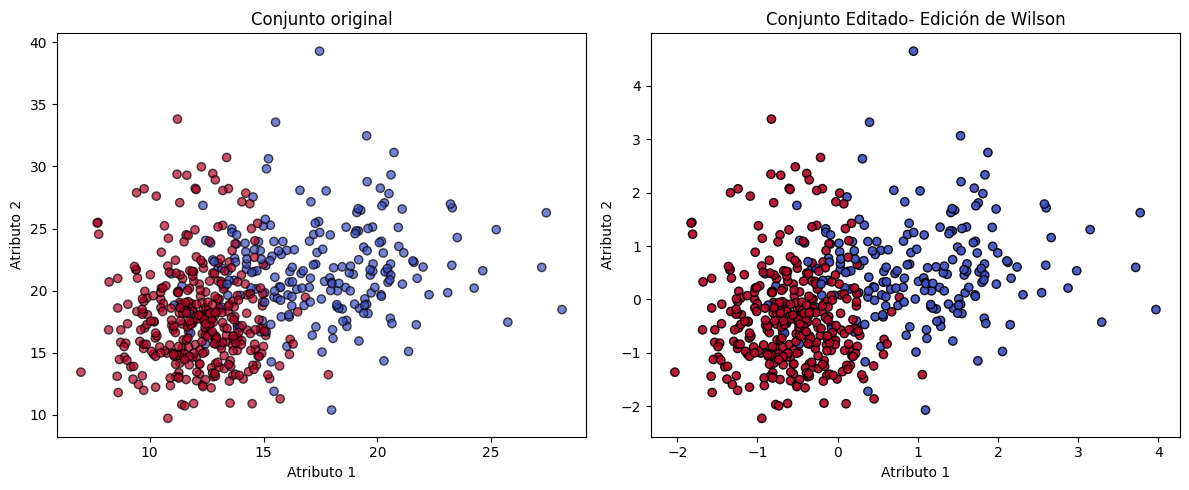

In [50]:
# 5. Aplicar técnica ENN (Edited Nearest Neighbor)
class ENN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def fit(self, X, y):
        # Validación inicial
        X, y = check_X_y(X, y, accept_sparse=False)

        mask = np.ones(len(y), dtype=bool)
        tmp_m = np.ones(len(y), dtype=bool)

        indices = list(range(len(y)))
        random.shuffle(indices)

        for i in indices:
            tmp_m[i] = False
            self.classifier.fit(X[tmp_m], y[tmp_m])
            x_i = X[i].reshape(1, -1)
            y_pred = self.classifier.predict(x_i)
            if y_pred[0] != y[i]:
                mask[i] = False
            tmp_m[i] = True

        self.X_ = X[mask]
        self.y_ = y[mask]
        self.sample_indices_ = np.where(mask)[0]
        self.reduction_ = 1 - len(self.y_) / len(y)
        return self

selector = ENN(n_neighbors=5)
selector.fit(X_scaled, y)

# Seleccionar subconjunto
idx = selector.sample_indices_
X_clean, y_clean = X_scaled[idx], y[idx]

print(f"Original: {len(y)} muestras")
print(f"Limpio:   {len(y_clean)} muestras")


# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_clean, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto Editado- Edición de Wilson")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias
- Realizar agrupamiento por clase y representar cada grupo con su centroide. Elige la mitad de los elementos de cada clase como el valor del número de centroides
- Generar un nuevo conjunto reducido con los centroides como prototipos



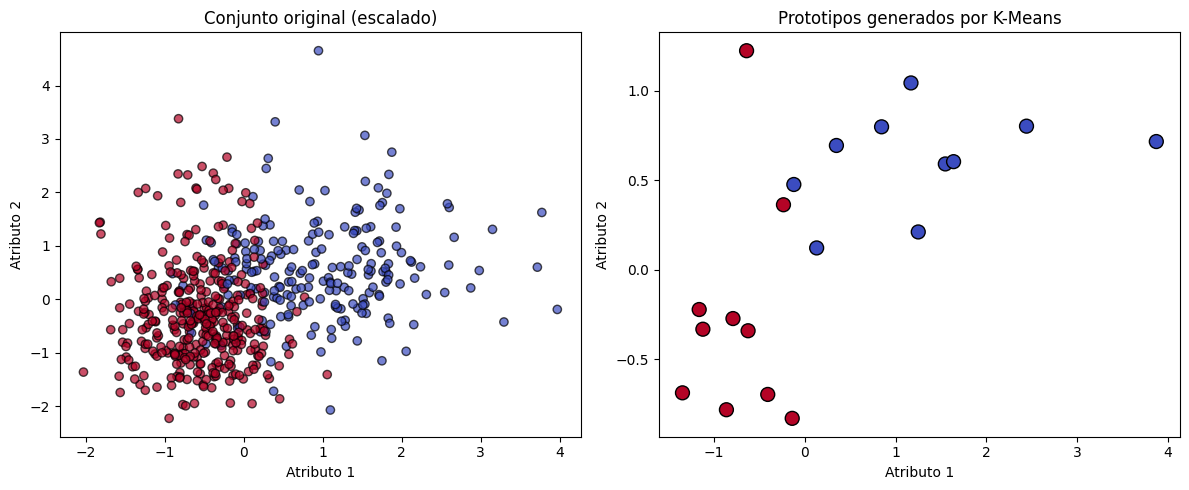

In [51]:
#Reducción mediante K-medias
prototypes_per_class = 10
classes = np.unique(y)
#Aplicar KMeans por clase
prototypes = []
labels = []

for c in classes:
    # Subconjunto de la clase actual
    class_data = X_scaled[y == c]

    # KMeans sobre los datos de la clase
    kmeans = KMeans(n_clusters=prototypes_per_class, random_state=42)
    kmeans.fit(class_data)

    # Guardar prototipos y sus etiquetas
    prototypes.append(kmeans.cluster_centers_)
    labels.extend([c] * prototypes_per_class)

#Concatenar resultados
X_proto = np.vstack(prototypes)
y_proto = np.array(labels)

#Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Conjunto original
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
axes[0].set_title("Conjunto original (escalado)")
axes[0].set_xlabel("Atributo 1")
axes[0].set_ylabel("Atributo 2")

#Prototipos generados
axes[1].scatter(X_proto[:, 0], X_proto[:, 1], c=y_proto, cmap='coolwarm', edgecolor='k', s=100)
axes[1].set_title("Prototipos generados por K-Means")
axes[1].set_xlabel("Atributo 1")
axes[1].set_ylabel("Atributo 2")

plt.tight_layout()
plt.show()

 --------------------------------------------------------------------------

##7. Entrenar SVM sobre cada conjunto reducido
- Entrenar un modelo SVM (SVC) sobre:
 * los datos originales
 * datos reducidos con CNN
 * datos reducidos con ENN
 * datos reducidos con K-medias
- Evaluar cada modelo con accuracy, F1-score



In [53]:
from sklearn.metrics import classification_report, accuracy_score
#7. Entrenar SVM sobre cada conjunto reducido
#Definimos la funcuon para entrenar el modelo
def SVM(X, y, nombre=""):
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Modelo SVM
    clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
    clf.fit(X_train, y_train)

    # Predicciones
    y_pred = clf.predict(X_test)

    # Resultados
    print(f"=== Resultados para {nombre} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("\n")

#Entrenamos el modelo con los diferentes datos
# Original
SVM(X_scaled, y, nombre="Datos Originales")

# CNN
SVM(X_cnn, y_cnn, nombre="CNN (Condensed Nearest Neighbor)")

# ENN
SVM(X_clean, y_clean, nombre="ENN (Edited Nearest Neighbor)")

# K-medidas (asumiendo que ya están en X_proto y y_proto)
SVM(X_proto, y_proto, nombre="K-medidas (Prototipos)")

=== Resultados para Datos Originales ===
Accuracy: 0.9708
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



=== Resultados para CNN (Condensed Nearest Neighbor) ===
Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.82      0.93      0.88        15

    accuracy                           0.83        24
   macro avg       0.84      0.80      0.81        24
weighted avg       0.84      0.83      0.83        24



=== Resultados para ENN (Edited Nearest Neighbor) ===
Accuracy: 0.9880
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.99      0

# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final
- Comparar las métricas de rendimiento obtenidas con cada técnica

Teniendo como referecia el acurracy y f-1 score de el data set original, podemos ver como el resto de los datga set tienden a bajar sus metricas menos en uno, lo que podria indicarnos que es la manera optima de tratar ese contexto de datos.

- Escribe tus conclusiones sobre el impacto de la reducción de la numerosidad

La reduccion de la numerosidad tiene un fuerte impacto hoy en dia que siempre se busca la mejora continua, y la manera de hacerlo hablando del contexto del analisis de datos, nos ayuda a evaluar y/o eliminar datos que pueden redundates o que posiblemente no tengan valor agregado para estar en el modelo como errores en la clasificacion por x o y motivo asi como datos que no fueron recolectados de manera correcta, este es un amplio campo de estudio porque si seguimos el termino de hacer mas con menos, el objetivo es contar con la menor cantidad de datos para que el moddelo aprenda sin tener tanto ruido de por medio y conservando solo la informacion relevante.

- ¿Cuál técnica funcionó mejor? ¿Qué ventajas y desventajas observaste?

La tecnica que funciono mejor es la de de ENN lo o Edicion de Wilson, que intenta hacer qu las freotneras de desicion sean mas sueaves y busca un menor solapamiento entre clases eliminando asi bastante ruido del conjunt de datos originales, en este caso en especifico la desventaja es que se eliminaron muy pocos datos del sistema, pero a su vez con 16 datos menos aproximadamente tuvo mejores resultados por la limpieza en el conjunto de datos.
